### **Проект по прогнозированию товарных запасов с использованием ML моделей и статистических методов ARIMA**


## Введение

Прогнозирование продаж является важной задачей для большинства компаний, так как позволяет принимать обоснованные решения по управлению запасами, планированию производства и маркетинговым стратегиям. В данном пет- проекте рассмотрим возможные проблемы с данными и как использовать  машинное обучение (ML) XGboost, статистические методы (ARIMA) для прогнозирования товарных запасов.


## Цели проекта

1. Собрать и подготовить данные о продажах 
2. Проанализировать временные ряды и выявить их характеристики.
3. Выявить аномалии с помощью Isolation Forest
4. Построить и оценить модели ARIMA
5. Построить и оценить модели машинного обучения XGboost
6. Построить и оценить модели машинного обучения Prophet
7. Сравнить результаты и выбрать наилучший подход для прогнозирования.

### 1.1. Источник данных

Для данного проекта мы будем использовать открытые данные о продажах которые скачаем на UCI Machine Learning Repository 

1.2. Подключение  необходимых библиотек и фреймворков

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, mean_squared_error,mean_absolute_percentage_error,r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime
pd.reset_option('display.max_rows',None)  # не использовать для big data  все строки 
pd.reset_option('display.max_columns',None)  # не использовать для big data все столбцы
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet
import matplotlib.dates as mdates
from pmdarima import auto_arima
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from pmdarima import model_selection
import pmdarima as pm
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import TimeSeriesSplit



1.3 Подготовка данных 

In [ ]:
  # Скачиваем данные   с UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Online+Retail)

online_retail = fetch_ucirepo(id=352) 
  
# Создаем датасет
X = online_retail.data.features 

# Сохраните DataFrame в CSV файл
X.to_csv('online_retail_dataset.csv', index=False)

In [42]:
# Считываем фаил с помощью pandas
df = pd.read_csv('C:/Users/Roman33/Desktop//ПЕТ-Проект/online_retail_dataset.csv') 

In [44]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [ ]:
# Считывание файла и переводим data в индекс необходимо для временых рядов , наш дасет имеет множество 
# необработаных данных так что такой способ  хорош когда не нужно обрабатывать данные тем самым оптимизирая процессы
# df_index_date = pd.read_csv(.../online_retail_dataset.csv', index_col= 'InvoiceDate', parse_dates= True)

## 2. Проанализировать временные ряды выявить их характеристики.

#### 2.1 Разведовательный Анализ данных (EDA)

In [45]:
# Первые 10 строк
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [46]:
# Количество строк и количество столбцов
df.shape

(541909, 8)

In [47]:
# Информация по типу данных и пропущенных значениях в datasete
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### В данных присутствуют  пропущенных значений в столбце Description  и CustomerID и столбец InvoiceDate имеет тип данных object


In [48]:
# Описательная статистика включает в себя все типы данных в датасете
df.describe(include="all")

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900,4070,4223,NaN,23260,NaN,NaN,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,10/31/2011 14:41,NaN,NaN,United Kingdom
freq,1114,2313,2369,NaN,1114,NaN,NaN,495478
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN
50%,NaN,NaN,NaN,3.000000,NaN,2.080000,15152.000000,NaN
75%,NaN,NaN,NaN,10.000000,NaN,4.130000,16791.000000,NaN


In [49]:
# Числовой тип данных
df.describe() 

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


### после вывода статистических показателей делаю вывод что в данных присутствуют :
*выбросы , пропущенные значения , пропущеные даты , отрицательные значения*

In [ ]:
# Изменения типа данных
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [90]:
# Переименования названия для удобства 
df = df.rename(columns={'InvoiceDate' : 'Date'})

Построим график для столбцов Quantity , согласно описательной статистики слишком большие значения возможно являются  выбросами или аномалиями

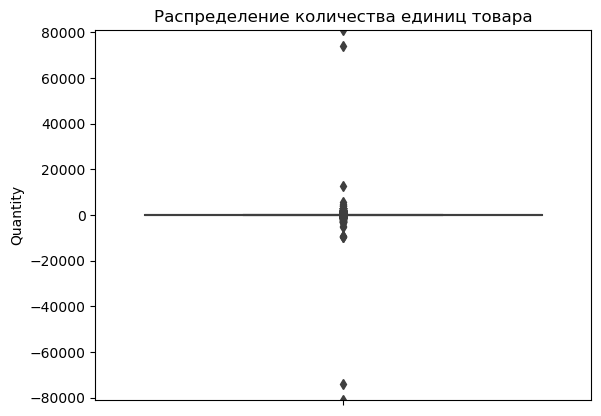

In [91]:
sns.boxplot(y='Quantity',data=df)
plt.ylim(df['Quantity'].min()-10, df['Quantity'].max()+10) # Установка пределов осей , пределы Y
plt.title("Распределение количества единиц товара")
plt.show;


### boxplot показывает что в данных есть экстремальные значения как отрицательные так и положительные , потверждая описательную статистику

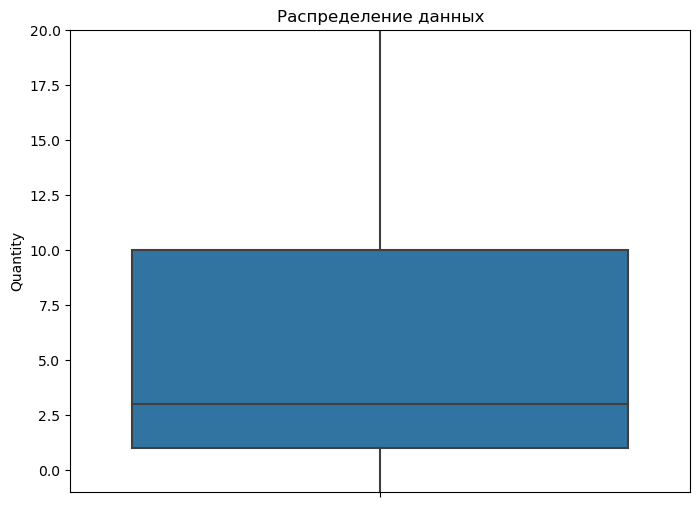

In [92]:
plt.figure(figsize=(8,6))
sns.boxplot(y='Quantity', data=df)
plt.ylim(-1,20)
plt.title("Распределение данных")
plt.show;

# Посмотрим на распределение данных 

Для понимания предметной области вычислим операции для данных

In [93]:
# Вычисляем Q1 (25-й процентиль) и Q3 (75-й процентиль)
Q_1 = df['Quantity'].quantile(0.25)
Q_3 = df['Quantity'].quantile(0.75)
print(f'25 квантиль равен {Q_1}, 75 квантиль {Q_3}')

25 квантиль равен 1.0, 75 квантиль 10.0


In [94]:
# Вычисляем IQR
IQR = Q_3 - Q_1

# Определяем границы для выбросов
lower_bound = Q_1 - 1.5 * IQR
upper_bound = Q_3 + 1.5 * IQR

# Фильтруем данные для нахождения выбросов
outliers = df[(df['Quantity'] < lower_bound) | (df['Quantity'] > upper_bound)]

#  Подсчитываем количество выбросов
num_outliers = outliers.shape[0]

print(f"Количество выбросов: {num_outliers}")
print("Выбросы:")
print(outliers)

Количество выбросов: 58619
Выбросы:
       InvoiceNo StockCode                         Description  Quantity  \
9         536367     84879       ASSORTED COLOUR BIRD ORNAMENT        32   
26        536370     22728           ALARM CLOCK BAKELIKE PINK        24   
27        536370     22727           ALARM CLOCK BAKELIKE RED         24   
30        536370     21883                    STARS GIFT TAPE         24   
31        536370     10002         INFLATABLE POLITICAL GLOBE         48   
...          ...       ...                                 ...       ...   
541876    581585     84945  MULTI COLOUR SILVER T-LIGHT HOLDER        24   
541882    581585     21916     SET 12 RETRO WHITE CHALK STICKS        24   
541883    581585     84692         BOX OF 24 COCKTAIL PARASOLS        25   
541891    581586     23275    SET OF 3 HANGING OWLS OLLIE BEAK        24   
541892    581586     21217       RED RETROSPOT ROUND CAKE TINS        24   

                      Date  UnitPrice  CustomerID  

In [95]:
max_value= (df[df['Quantity']==df['Quantity'].max()])
max_value

,InvoiceNo,StockCode,Description,Quantity,Date,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom


In [96]:
min_value = (df[df['Quantity']== df['Quantity'].min()])
min_value

,InvoiceNo,StockCode,Description,Quantity,Date,UnitPrice,CustomerID,Country
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


#### В датасете присутствуют не точные данные исходя из контекста датасета , в реальном  бизнес проекте необходимо было бы выяснить происхождение данных , почему количество товаров являются отрицательными значением,почему стоимость за едину товара не указана,почему есть пропуски значений по датам , но так как мы работает с данными которые для общего пользования, будем считать что это аномалии и они не являются частью естественного процесса.

In [97]:
anomaly = df[df['Description']=='PAPER CRAFT , LITTLE BIRDIE']
anomaly

,InvoiceNo,StockCode,Description,Quantity,Date,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


#### Данные нерегулярные всего два значения , при иследовании данных в реальных бизнес задачах подобные случаи требуют внимания и необходимо было бы выяснить как появились такие данные 

### Для построения модели Arima , Prophet и XGboost будем использовать одну переменную Quantity 

#### Удалим столбцы с которыми не будем работать для дальнейшего построенния моделей

2 способа 

In [99]:
# Отбор нужных столбцов
timeseries_one_product = df[['Description','Date','Quantity']]
timeseries_one_product.sample(3)

,Description,Date,Quantity
134083,DOORMAT FAIRY CAKE,2011-03-25 14:53:00,4
124856,AREA PATROLLED METAL SIGN,2011-03-18 13:19:00,4
75159,WOVEN FROST CUSHION COVER,2011-01-28 14:25:00,2


In [100]:
# удаление столбцов
time_series = df.drop(['Country','CustomerID','InvoiceNo','StockCode'], axis=True)
time_series.head()

,Description,Quantity,Date,UnitPrice
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55
1,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39
2,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75
3,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39
4,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39


### Посмотрим на описание Description , для выявления последовательности во временом ряду

In [101]:
product = time_series['Description'].value_counts()
product

Description
WHITE HANGING HEART T-LIGHT HOLDER     2369
REGENCY CAKESTAND 3 TIER               2200
JUMBO BAG RED RETROSPOT                2159
PARTY BUNTING                          1727
LUNCH BAG RED RETROSPOT                1638
                                       ... 
Missing                                   1
historic computer difference?....se       1
DUSTY PINK CHRISTMAS TREE 30CM            1
WRAP BLUE RUSSIAN FOLKART                 1
PINK BERTIE MOBILE PHONE CHARM            1
Name: count, Length: 4223, dtype: int64

### Столбец Description имеет разные изменения по времене , это говарит о том что ряды нерегулярные

# Нерегулярные ряды

In [102]:
one_product_1 = time_series[time_series['Description']=='DUSTY PINK CHRISTMAS TREE 30CM']
one_product_1

,Description,Quantity,Date,UnitPrice
11866,DUSTY PINK CHRISTMAS TREE 30CM,1,2010-12-06 12:15:00,1.25


In [103]:
one_product = time_series[time_series['Description']=='PINK BAROQUE FLOCK CANDLE HOLDER']
one_product

,Description,Quantity,Date,UnitPrice
7234,PINK BAROQUE FLOCK CANDLE HOLDER,2,2010-12-03 15:45:00,5.95


#### видно что есть товары которые продавались один раз , можно сделать вывод что не все товары подходят для построения моделей прогноза 

#### **Если данные ситуации присутствуют в данных для бизнес процессов то необходимо более детально изучить предметную область и собрать необходимое количество данных**

### Отфильтруем по 1 товару и для него провидем иследование

In [ ]:
# # Фильтрация по 'Description' для других товаров
# feiltred_description = 'WHITE HANGING HEART T-LIGHT HOLDER'
# df_filtered=df[df['Description'] == feiltred_description]

In [104]:
one_product_1 = time_series[time_series['Description']=='WHITE HANGING HEART T-LIGHT HOLDER']
one_product_1

,Description,Quantity,Date,UnitPrice
0,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55
49,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:02:00,2.55
66,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 09:32:00,2.55
220,WHITE HANGING HEART T-LIGHT HOLDER,64,2010-12-01 10:19:00,2.55
262,WHITE HANGING HEART T-LIGHT HOLDER,32,2010-12-01 10:39:00,2.55
...,...,...,...,...
537291,WHITE HANGING HEART T-LIGHT HOLDER,1,2011-12-08 10:59:00,2.95
537326,WHITE HANGING HEART T-LIGHT HOLDER,2,2011-12-08 11:15:00,2.95
537852,WHITE HANGING HEART T-LIGHT HOLDER,6,2011-12-08 12:28:00,2.95
539979,WHITE HANGING HEART T-LIGHT HOLDER,32,2011-12-08 18:03:00,2.55


In [106]:
one_product_1.describe()

,Quantity,Date,UnitPrice
count,2369.000000,2369,2369.000000
mean,14.907978,2011-06-07 00:52:37.382862080,3.204251
min,-1930.000000,2010-12-01 08:26:00,0.000000
25%,3.000000,2011-03-03 14:43:00,2.950000
50%,6.000000,2011-05-31 08:50:00,2.950000
75%,12.000000,2011-09-19 13:20:00,2.950000
max,1930.000000,2011-12-08 19:55:00,6.770000
std,81.881444,NaN,0.990687


In [107]:
(one_product_1[one_product_1['Quantity']==one_product_1['Quantity'].min()])

,Description,Quantity,Date,UnitPrice
160143,WHITE HANGING HEART T-LIGHT HOLDER,-1930,2011-04-18 13:08:00,2.55


### предположим что это ошибка и будем считать это аномалией

In [108]:
(one_product_1[one_product_1['Quantity']==one_product_1['Quantity'].max()])

,Description,Quantity,Date,UnitPrice
52709,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-01-11 12:55:00,2.55
160542,WHITE HANGING HEART T-LIGHT HOLDER,1930,2011-04-18 13:20:00,2.40


### Cогласно данным есть 2 дня в которые покупки данного товара привышают mean	14.907978
### Предположим что это оптовая покупка которая за ранее согласовывается для необходимого количества и на прогнозирование остатков влиять не будет

#### Удалим эти значения

In [116]:
# Находим индекс(ы) максимального значения 
max_index = one_product_1['Quantity'][one_product_1['Quantity'] == one_product_1['Quantity'].max()].index
max_index

Index([52709, 160143, 160542], dtype='int64')

In [110]:
index_label = 52709

In [111]:
if index_label in one_product_1.index:
    row = one_product_1.loc[index_label]
    print(row)
else:
    print(f'{index_label} no')    

Description    WHITE HANGING HEART T-LIGHT HOLDER
Quantity                                     1930
Date                          2011-01-11 12:55:00
UnitPrice                                    2.55
Name: 52709, dtype: object


In [112]:
one_product_1.loc[52709]

Description    WHITE HANGING HEART T-LIGHT HOLDER
Quantity                                     1930
Date                          2011-01-11 12:55:00
UnitPrice                                    2.55
Name: 52709, dtype: object

In [113]:
negative = one_product_1[one_product_1['Quantity']<0]
negative.head()

,Description,Quantity,Date,UnitPrice
14529,WHITE HANGING HEART T-LIGHT HOLDER,-1,2010-12-07 12:45:00,2.55
24911,WHITE HANGING HEART T-LIGHT HOLDER,-1,2010-12-10 15:01:00,2.55
29949,WHITE HANGING HEART T-LIGHT HOLDER,-1,2010-12-14 13:06:00,2.95
34292,WHITE HANGING HEART T-LIGHT HOLDER,-500,2010-12-17 09:37:00,2.55
38444,WHITE HANGING HEART T-LIGHT HOLDER,-24,2010-12-20 12:25:00,2.95


### предположим что отрицательные значения это ошибка и значения у нас должны быть только положительными 

In [114]:
# Метод abs переводит все отрицательные значения в положительные 
one_product_1['Quantity']= one_product_1['Quantity'].abs()


C:\Users\Roman33\AppData\Local\Temp\ipykernel_7744\378419544.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  one_product_1['Quantity']= one_product_1['Quantity'].abs()


In [115]:
one_product_1.describe()

,Quantity,Date,UnitPrice
count,2369.000000,2369,2369.000000
mean,17.084424,2011-06-07 00:52:37.382862080,3.204251
min,1.000000,2010-12-01 08:26:00,0.000000
25%,3.000000,2011-03-03 14:43:00,2.950000
50%,6.000000,2011-05-31 08:50:00,2.950000
75%,12.000000,2011-09-19 13:20:00,2.950000
max,1930.000000,2011-12-08 19:55:00,6.770000
std,81.454968,NaN,0.990687


In [117]:
# Удаляем строки по их индексам
one_product_1 = one_product_1.drop(max_index)

In [123]:
if index_label in one_product_1.index:
    row = one_product_1.loc[index_label]
    print(row)
else:
    print(f'{index_label} удален')    

52709 удален


## приведем к одинаковому интервалу

### даные имеют не равномерное распределение по времени сложим все значения за день и будем строить прогноз на основании значения за день

In [121]:
# Группировка по дню и сложение количества за день
one_product_day = one_product_1.groupby(one_product_1['Date'].dt.to_period('D'))['Quantity'].sum().reset_index()

In [124]:
one_product_day.head()

,Date,Quantity
0,2010-12-01,454
1,2010-12-02,309
2,2010-12-03,60
3,2010-12-05,198
4,2010-12-06,161


# есть пропущеные даты 

## Для прогнозирования временых рядов отсутствующие даты могут повлиять на качество прогноза 

In [125]:
one_product_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype    
---  ------    --------------  -----    
 0   Date      304 non-null    period[D]
 1   Quantity  304 non-null    int64    
dtypes: int64(1), period[D](1)
memory usage: 4.9 KB


In [126]:
# Необходимо перевести тип данных для Date
one_product_day['Date']= (one_product_day['Date']).dt.to_timestamp()

In [127]:
# Создадим список дат 
full_date = pd.date_range(start=one_product_day['Date'].min(), end=one_product_day['Date'].max())
# Создадим датасет с созданными датами
full_date = pd.DataFrame({'Date': full_date})
# Обьядиним 2 датасета для дальнейших манипуляций 
one_product_day = full_date.merge(one_product_day, on='Date', how='left')

In [128]:
# вывод пропущеных значений 
one_product_day[one_product_day.isnull().any(axis=1)]


,Date,Quantity
3,2010-12-04,NaN
10,2010-12-11,NaN
17,2010-12-18,NaN
23,2010-12-24,NaN
24,2010-12-25,NaN
...,...,...
339,2011-11-05,NaN
346,2011-11-12,NaN
353,2011-11-19,NaN
360,2011-11-26,NaN


## пропущенно 69 дней и  69 значений

Это говарит о том что при построение моделей достичь высокого качества будет сложно.Для бизнес задач такое количество пропусков может существенно повлиять на результаты, заполнять пропущеные значения необходимо реальными данными из сферы деятельности.

In [135]:
one_product_day.describe()

,Date,Quantity
count,373,304.000000
mean,2011-06-05 00:00:00,114.088816
min,2010-12-01 00:00:00,3.000000
25%,2011-03-04 00:00:00,38.000000
50%,2011-06-05 00:00:00,77.000000
75%,2011-09-06 00:00:00,132.000000
max,2011-12-08 00:00:00,1265.000000
std,NaN,143.651653


## Варианты заполнения пропущенных значений 

In [136]:
# Перевод date  в индекс
one_product_day =  one_product_day.set_index('Date')

In [137]:
one_product_day.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 373 entries, 2010-12-01 to 2011-12-08
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Quantity  304 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


In [138]:
# Заполнение средним значением

product_mean = round(one_product_day['Quantity'].fillna(one_product_day['Quantity'].mean()),2)
product_mean.head()

Date
2010-12-01    454.00
2010-12-02    309.00
2010-12-03     60.00
2010-12-04    114.09
2010-12-05    198.00
Name: Quantity, dtype: float64

In [139]:
# Заполнение пропущенных значений медианным 

product_median = one_product_day['Quantity'].fillna(one_product_day['Quantity'].median()) 
product_median.head()

Date
2010-12-01    454.0
2010-12-02    309.0
2010-12-03     60.0
2010-12-04     77.0
2010-12-05    198.0
Name: Quantity, dtype: float64

In [140]:
# Заполнение значениями соседних строк значения из соседних строк для заполнения пропущенных значений. Это может быть сделано с помощью методов ffill (вперед) и bfill (назад).
product_up = one_product_day['Quantity'].fillna(method='ffill')  # Заполнение вперед
product_up

Date
2010-12-01    454.0
2010-12-02    309.0
2010-12-03     60.0
2010-12-04     60.0
2010-12-05    198.0
              ...  
2011-12-04      8.0
2011-12-05    313.0
2011-12-06     40.0
2011-12-07    202.0
2011-12-08     58.0
Name: Quantity, Length: 373, dtype: float64

In [141]:
product_back = one_product_day['Quantity'].fillna(method='bfill')  # Заполнение назад
product_back

Date
2010-12-01    454.0
2010-12-02    309.0
2010-12-03     60.0
2010-12-04    198.0
2010-12-05    198.0
              ...  
2011-12-04      8.0
2011-12-05    313.0
2011-12-06     40.0
2011-12-07    202.0
2011-12-08     58.0
Name: Quantity, Length: 373, dtype: float64

In [142]:
# Интерполяция
one_product_day_interpolate = one_product_day['Quantity'].interpolate(method='time')  # интерполяция для временных рядов

## Интерполяция позволяет заполнять пропущенные значения на основе других значений в столбце. Этот способ походит для временных рядов.

In [143]:
one_product_day_interpolate

Date
2010-12-01    454.0
2010-12-02    309.0
2010-12-03     60.0
2010-12-04    129.0
2010-12-05    198.0
              ...  
2011-12-04      8.0
2011-12-05    313.0
2011-12-06     40.0
2011-12-07    202.0
2011-12-08     58.0
Name: Quantity, Length: 373, dtype: float64

In [46]:
# Сохраняем timeseries
%store  one_product_day_interpolate 

Stored 'one_product_day_interpolate' (Series)


In [ ]:
%store -r one_product_day_interpolate

#### Для определения более точного качества прогноза алгоритмов необходимо проверить все значения 

In [144]:
# Создатим датасет
one_product_day_interpolate.to_csv('time_series_data.csv') 

In [145]:
timeseries_one_product = pd.read_csv('time_series_data.csv',index_col='Date')
timeseries_one_product.head()

,Quantity
Date,
2010-12-01,454.0
2010-12-02,309.0
2010-12-03,60.0
2010-12-04,129.0
2010-12-05,198.0


In [146]:
timeseries_one_product[timeseries_one_product['Quantity']>100]

,Quantity
Date,
2010-12-01,454.0
2010-12-02,309.0
2010-12-04,129.0
2010-12-05,198.0
2010-12-06,161.0
...,...
2011-11-29,117.0
2011-11-30,316.0
2011-12-02,117.0


# Значения которые повлияют на качество результатов алгоритмов

In [147]:
timeseries_one_product.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373 entries, 2010-12-01 to 2011-12-08
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Quantity  373 non-null    float64
dtypes: float64(1)
memory usage: 5.8+ KB


# 3.Поиск аномалий с помощью Isolation Forest

In [148]:
# Загрузка данных 
timeseries_one_product = pd.read_csv('time_series_data.csv',index_col = 'Date')

In [149]:
# Сортировка по дате
timeseries_one_product = timeseries_one_product.sort_values(by='Date')

In [150]:
# Вывод 5 строк
timeseries_one_product.head()

,Quantity
Date,
2010-12-01,454.0
2010-12-02,309.0
2010-12-03,60.0
2010-12-04,129.0
2010-12-05,198.0


In [151]:
print(timeseries_one_product.index)
print(type(timeseries_one_product.index))

Index(['2010-12-01', '2010-12-02', '2010-12-03', '2010-12-04', '2010-12-05',
       '2010-12-06', '2010-12-07', '2010-12-08', '2010-12-09', '2010-12-10',
       ...
       '2011-11-29', '2011-11-30', '2011-12-01', '2011-12-02', '2011-12-03',
       '2011-12-04', '2011-12-05', '2011-12-06', '2011-12-07', '2011-12-08'],
      dtype='object', name='Date', length=373)
<class 'pandas.core.indexes.base.Index'>


In [152]:
# перевод индекса в тип DatetimeIndex необходимо для правильного отображения даты
timeseries_one_product.index = pd.to_datetime(timeseries_one_product.index)

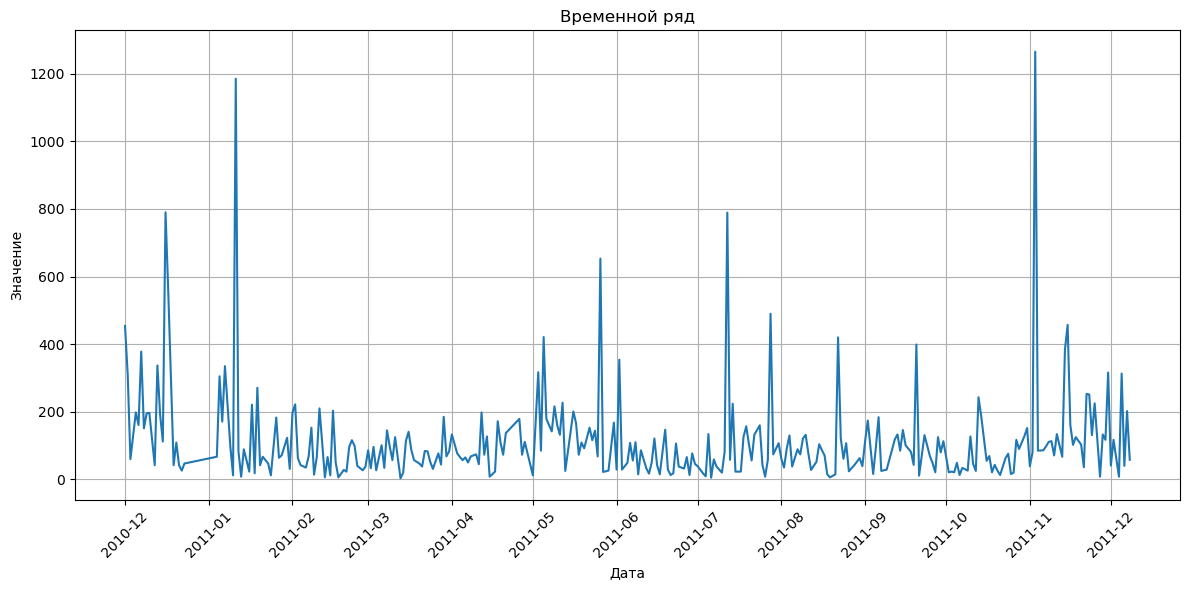

In [153]:
plt.figure(figsize=(12, 6))
plt.plot(timeseries_one_product.index, timeseries_one_product.values) # Явно передаем даты и значения
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Временной ряд')
plt.grid(True)
plt.tight_layout()
plt.show()

#### **Есть значения которые будут влиять на качество прогноза**

## Найдем эти значения с помощью Isolation Forest

In [154]:
from sklearn.ensemble import IsolationForest

In [155]:
model = IsolationForest(n_estimators=100,contamination=0.05,random_state=42)

In [156]:
model

IsolationForest(contamination=0.05, random_state=42)

In [157]:
model.fit(timeseries_one_product[['Quantity']])

IsolationForest(contamination=0.05, random_state=42)

In [158]:
timeseries_one_product["Anomaliu"] = model.predict(timeseries_one_product[['Quantity']])

In [159]:
timeseries_one_product.head()

,Quantity,Anomaliu
Date,,
2010-12-01,454.0,-1
2010-12-02,309.0,1
2010-12-03,60.0,1
2010-12-04,129.0,1
2010-12-05,198.0,1


In [160]:
anomalies = timeseries_one_product[timeseries_one_product['Anomaliu'] == -1]

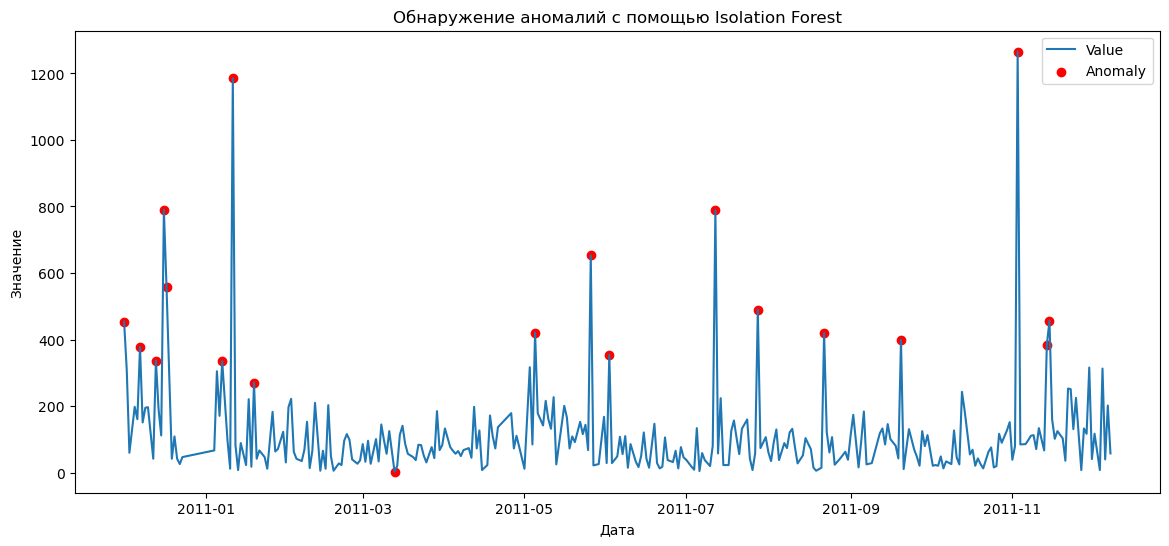

In [161]:
plt.figure(figsize=(14, 6))
plt.plot(timeseries_one_product['Quantity'], label='Value')
plt.scatter(anomalies.index, anomalies['Quantity'], color='red', label='Anomaly')
plt.title('Обнаружение аномалий с помощью Isolation Forest')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [162]:
anomalies

,Quantity,Anomaliu
Date,,
2010-12-01,454.0,-1
2010-12-07,378.0,-1
2010-12-13,337.0,-1
2010-12-16,790.0,-1
2010-12-17,558.0,-1
2011-01-07,335.0,-1
2011-01-11,1185.0,-1
2011-01-19,271.0,-1
2011-03-13,3.0,-1


# Создадим и сохраним полученые результаты в фаил 

In [163]:
timeseries_one_product.to_csv('anomaly_IF.csv')

In [164]:
anomalies.to_csv('anomaly.csv')

### Данные которые повлияют на качество прогноза алгоритмов, их нужно преобразовывать.
Оставим как есть посмотрим как алгоритмы справятся с такими значениями  

# 4.Построение предсказаний для одного товара модель avto_ARIMA

In [165]:
timeseries_one_product = pd.read_csv('time_series_data.csv',index_col='Date')

In [166]:
# перевод индекса в тип DatetimeIndex необходимо для правильного отображения даты
timeseries_one_product.index = pd.to_datetime(timeseries_one_product.index)

## Проверка временных рядов на стационарность

Стационарный временной ряд — это ряд, статистические свойства которого, такие как среднее значение и дисперсия, не меняются со временем.

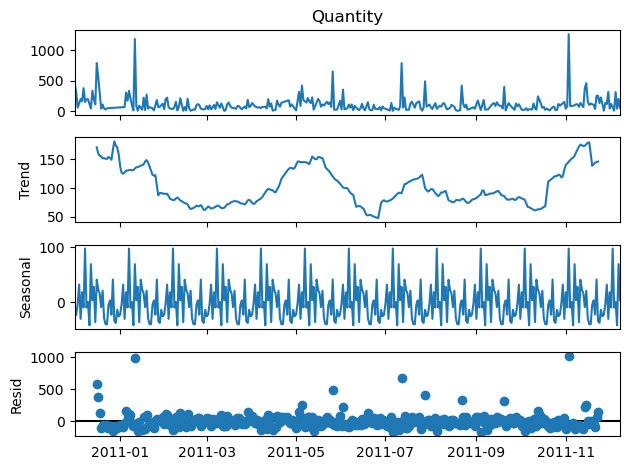

In [167]:
# Декомпозиция временного ряда
result = seasonal_decompose(timeseries_one_product['Quantity'], model='additive', period=30)

# Визуализация результатов
result.plot()
plt.show()

In [168]:
# тест Дики-Фуллера (ADF),
result = adfuller(timeseries_one_product['Quantity'])

In [169]:
result = adfuller(timeseries_one_product['Quantity'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key,value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[1] > 0.05:
    print("Данные нестационарные")
else:
    print("Данные стационарные")

ADF Statistic: -17.599185
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571
Данные стационарные


#### Рассмотрим, как интерпретировать графики автокорреляции (ACF) и частичной автокорреляции (PACF)<br>
#### Эти графики являются важными инструментами для анализа временных рядов и могут помочь в выборе модели для прогнозирования.

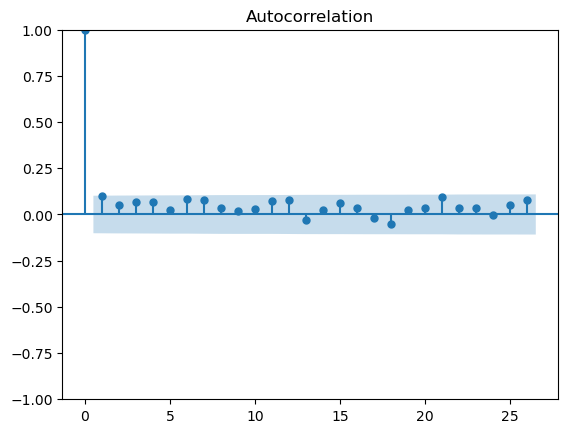

In [170]:
# Построение графика ACF
plot_acf(timeseries_one_product)
plt.show()


**График ACF (Autocorrelation Function)**

ACF показывает автокорреляцию временного ряда с самим собой на различных временных лагов. Это означает, что он показывает, насколько текущие значения временного ряда коррелируют с его прошлыми значениями.

Как читать график ACF:
• Ось X: Лаги (разницы во времени).

• Ось Y: Значения автокорреляции (от -1 до 1).

• Значения: Если значение ACF на определенном лаге значительно выше нуля, это указывает на наличие положительной автокорреляции, и наоборот для отрицательной автокорреляции.

• Доверительные интервалы: Обычно график включает горизонтальные линии, которые представляют доверительные интервалы (обычно 95%). Если значения ACF выходят за пределы этих линий, это может указывать на значимую автокорреляцию на данном лаге.

• Падение ACF: Если ACF быстро падает до нуля, это может указывать на то, что ряд является стационарным, и, возможно, не требует дифференцирования.

• Долгосрочная автокорреляция: Если ACF показывает значительную корреляцию на больших лагах, это может указывать на наличие тренда в данных.
  
• Если на лаге 1 ACF = 0.8 и попадает за пределы доверительных интервалов, это означает, что текущие значения временного ряда сильно коррелируют с предыдущими значениями.

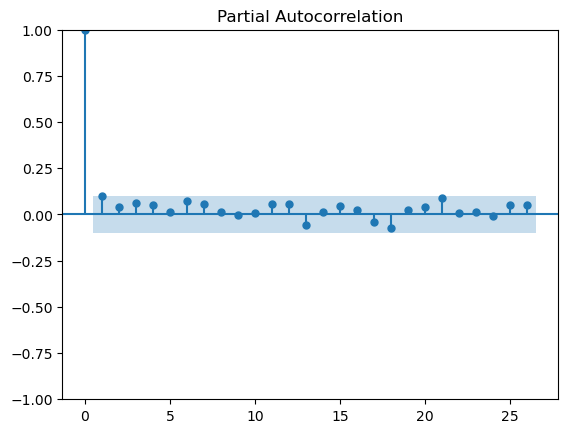

In [171]:
# Построение графика PACF
plot_pacf(timeseries_one_product)
plt.show;

**График PACF (Partial Autocorrelation Function)**

PACF показывает частичную автокорреляцию временного ряда с самим собой на различных временных лагов. Это означает, что он показывает корреляцию между текущими значениями и прошлыми значениями, исключая влияние промежуточных значений.

Как читать график PACF:

• Ось X: Лаги (разницы во времени).

• Ось Y: Значения частичной автокорреляции (от -1 до 1).

• Значения: Как и в ACF, если значение PACF на определенном лаге значительно выше нуля, это указывает на наличие положительной частичной автокорреляции, и наоборот для отрицательной.

• Падение PACF: Если PACF быстро падает до нуля, это может указывать на то, что ряд является стационарным.

• Значимые лаги: Если значения PACF остаются значительными на первых нескольких лагах, это может указывать на порядок авторегрессии (p) в модели ARIMA.

• Если на лаге 1 PACF = 0.7 и попадает за пределы доверительных интервалов, это также указывает на сильную корреляцию, но уже без влияния промежуточных значений.

• Если PACF падает до нуля после лагов 1-2, это может указывать на порядок авторегрессии (p) в модели ARIMA.



In [172]:
# Разделение данных
tscv = TimeSeriesSplit(n_splits=2, test_size=10)

In [173]:
for train_index, test_index in tscv.split(timeseries_one_product):
    X_train, X_test = timeseries_one_product.iloc[train_index], timeseries_one_product.iloc[test_index]
    print("Train set:")
    print(X_train)
    print("\nTest set:")
    print(X_test)

Train set:
            Quantity
Date                
2010-12-01     454.0
2010-12-02     309.0
2010-12-03      60.0
2010-12-04     129.0
2010-12-05     198.0
...              ...
2011-11-14     384.0
2011-11-15     457.0
2011-11-16     160.0
2011-11-17     102.0
2011-11-18     125.0

[353 rows x 1 columns]

Test set:
            Quantity
Date                
2011-11-19     114.0
2011-11-20     103.0
2011-11-21      36.0
2011-11-22     253.0
2011-11-23     251.0
2011-11-24     131.0
2011-11-25     225.0
2011-11-26     116.5
2011-11-27       8.0
2011-11-28     133.0
Train set:
            Quantity
Date                
2010-12-01     454.0
2010-12-02     309.0
2010-12-03      60.0
2010-12-04     129.0
2010-12-05     198.0
...              ...
2011-11-24     131.0
2011-11-25     225.0
2011-11-26     116.5
2011-11-27       8.0
2011-11-28     133.0

[363 rows x 1 columns]

Test set:
            Quantity
Date                
2011-11-29     117.0
2011-11-30     316.0
2011-12-01      41.0
2011-

In [ ]:
# # Разделение данных на train и test
# Y_train_timeseries_one_product = timeseries_one_product[:-61] 
# Y_test_timeseries_one_product = timeseries_one_product[-61:]


In [174]:
# перевод индекса в тип DatetimeIndex необходимо для правильного отображения даты
X_test.index = pd.to_datetime(X_test.index)

In [175]:
# перевод индекса в тип DatetimeIndex необходимо для правильного отображения даты
X_train.index = pd.to_datetime(X_train.index)

In [176]:
# частота 
X_train = X_train.asfreq('D')

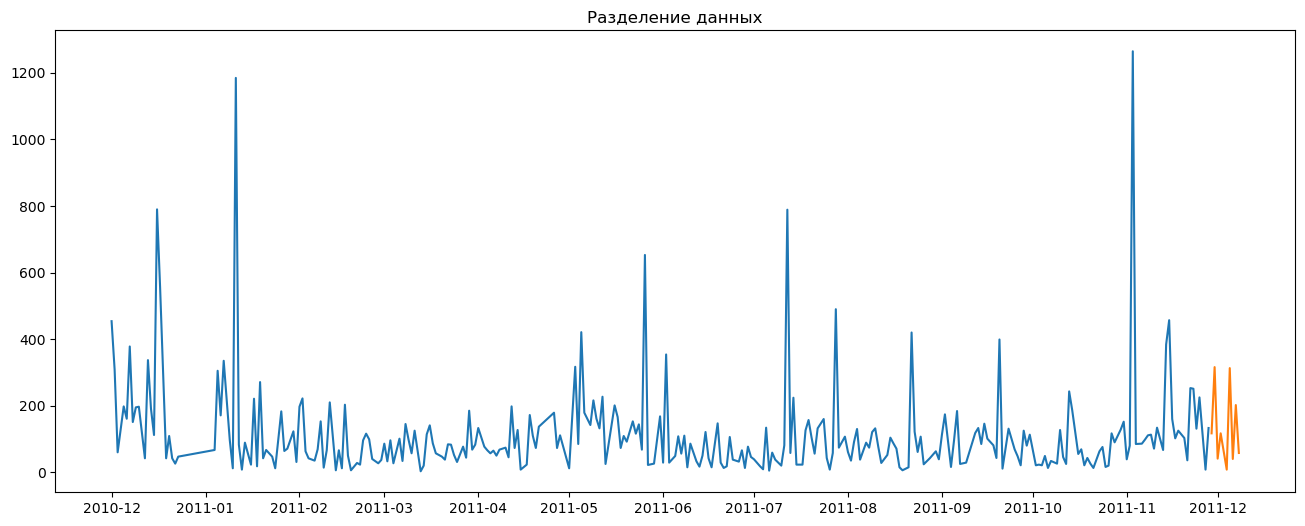

In [177]:
# 5. Визуализация результатов
plt.figure(figsize=(16, 6))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.plot(X_train)
plt.plot(X_test)
plt.title("Разделение данных")
plt.show;


# Автоматический подбор параметров ARIMA

In [178]:
model = auto_arima(X_train['Quantity'],  # Входной временной ряд (pandas Series или numpy array)

                   start_p=0,             # Начальное значение для параметра p (порядок AR).  С какого значения начинать поиск параметра p
                   start_q=0,             # Начальное значение для параметра q (порядок MA).  С какого значения начинать поиск параметра q

                   max_p=10,              # Максимальное значение, которое может принимать параметр p.  Ограничение сверху для параметра p
                   max_q=10,              # Максимальное значение, которое может принимать параметр q.  Ограничение сверху для параметра q

                   m=1,                 # Частота сезонности (число периодов в сезонном цикле). m=1 означает отсутствие сезонности.  Для ежемесячных данных с годовой сезонностью m=12

                   d=0,                 # Порядок интегрирования (количество раз, которое нужно продифференцировать ряд, чтобы сделать его стационарным).  0 означает, что дифференцирование не выполняется.  Лучше не задавать явно, а позволить auto_arima выбрать автоматически

                   seasonal=False,        # Указывает, является ли модель сезонной (использовать SARIMA вместо ARIMA). False означает, что будет использоваться только ARIMA, а не SARIMA

                   information_criterion='aic',  # Критерий, используемый для выбора лучшей модели. Возможные значения: 'aic', 'aicc', 'bic', 'hqic'. 'aic' - Akaike Information Criterion (стремится к минимальному значению)

                   error_action='ignore',  # Что делать, если во время подбора модели возникают ошибки. 'ignore' означает, что ошибки будут игнорироваться, и поиск продолжится

                   suppress_warnings=False,  # Подавлять ли предупреждения, возникающие во время подбора модели.  Рекомендуется False для отладки

                   stepwise=False,          # Использовать ли stepwise-алгоритм для поиска оптимальной модели. Stepwise-алгоритм ускоряет поиск, но не всегда находит оптимальную модель. При True параметры start_p, start_q, max_p, max_q, d и m используются только для инициализации

                   trace=True,              # Выводить ли информацию о процессе подбора модели (какие модели тестируются, какие значения критерия)

                   #approximation=False       # Использовать ли приближенный метод для оценки правдоподобия. Приближенный метод может быть быстрее, но менее точным
                  )

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4763.005, Time=0.33 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=4709.711, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=4691.419, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=4675.037, Time=0.17 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=4664.195, Time=0.21 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=4662.165, Time=0.25 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=4678.372, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=4580.691, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=4581.856, Time=0.26 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=4583.789, Time=0.39 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=4585.706, Time=0.56 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4652.753, Time=0.11 sec


c:\Users\Roman33\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4581.882, Time=0.34 sec


c:\Users\Roman33\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Roman33\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,0,2)(0,0,0)[0]             : AIC=4584.689, Time=0.30 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=4585.795, Time=0.39 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4633.631, Time=0.16 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4583.805, Time=0.44 sec


c:\Users\Roman33\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Roman33\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,0,2)(0,0,0)[0]             : AIC=4585.812, Time=0.45 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=4623.159, Time=0.18 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=4585.656, Time=0.47 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=4621.035, Time=0.09 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 5.520 seconds


In [179]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  363
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -2287.345
Date:                Fri, 21 Feb 2025   AIC                           4580.691
Time:                        19:44:17   BIC                           4592.374
Sample:                    12-01-2010   HQIC                          4585.335
                         - 11-28-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9987      0.001    760.725      0.000       0.996       1.001
ma.L1         -0.9404      0.025    -37.992      0.000      -0.989      -0.892
sigma2      1.728e+04    359.669     48.058      0.000    1.66e+04     1.8e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):             17111.24
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             4.64
Prob(H) (two-sided):                  0.31   Kurtosis:                        35.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

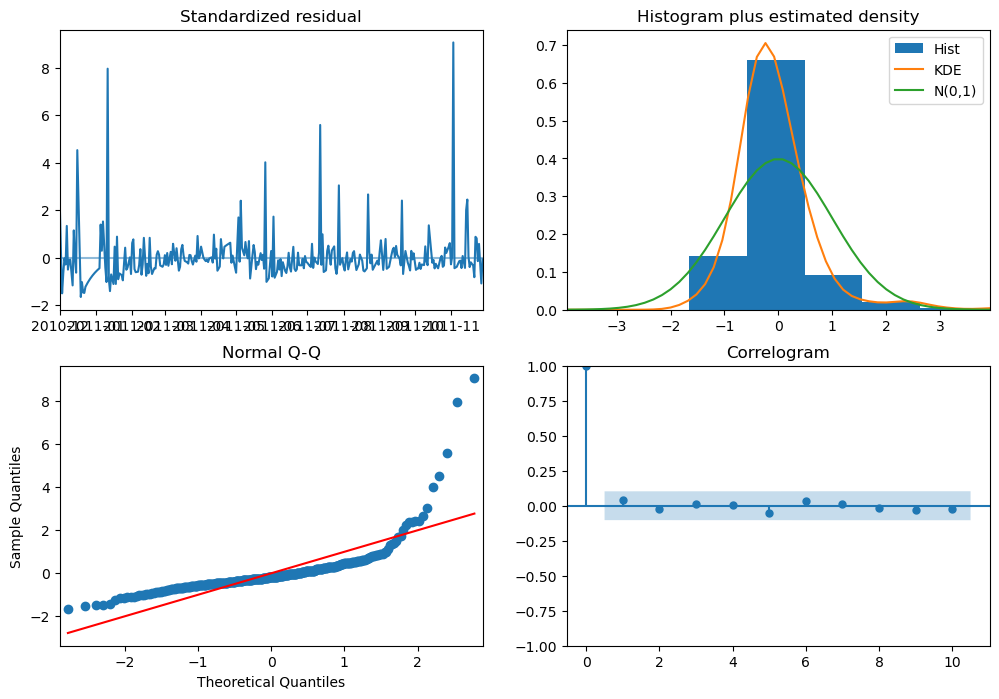

In [180]:
model.plot_diagnostics(figsize=(12, 8))
plt.show()

In [181]:
# Анализ остатков (Residual Analysis)
residuals = model.resid()  # Получение остатков

In [182]:
residuals

Date
2010-12-01    454.000000
2010-12-02     37.417885
2010-12-03   -225.270727
2010-12-04    -94.159142
2010-12-05     -4.447149
                 ...    
2011-11-24    -19.498871
2011-11-25     75.828740
2011-11-26    -36.906399
2011-11-27   -143.059623
2011-11-28     -9.523211
Freq: D, Length: 363, dtype: float64

In [183]:
from statsmodels.stats.diagnostic import normal_ad

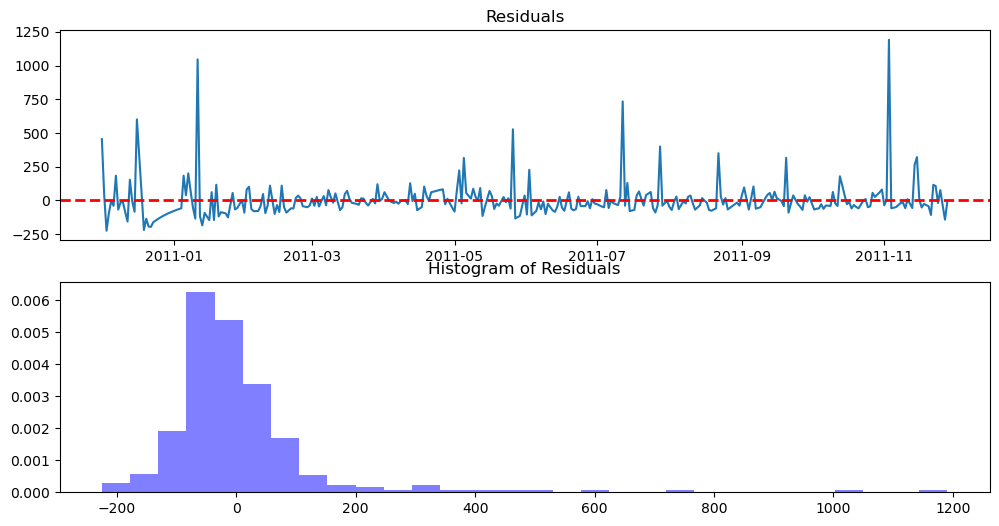

In [184]:

# Визуализация остатков
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(residuals)
plt.title('Residuals')
plt.axhline(0, color='red', linestyle='--', lw=2)
plt.subplot(212)
plt.hist(residuals, bins=30, density=True, alpha=0.5, color='blue')
plt.title('Histogram of Residuals')
plt.show()





In [100]:
# Проверка нормальности остатков с помощью теста Андресона-Дарлинга
statistic, p_value = normal_ad(residuals)
print(f'Anderson-Darling statistic: {statistic}, p-value: {p_value}')

if p_value < 0.05:
    print("Остатки не нормально распределены (отклонение от нормальности).")
else:
    print("Остатки нормально распределены.")

Anderson-Darling statistic: inf, p-value: 0.0
Остатки не нормально распределены (отклонение от нормальности).


c:\Users\Roman33\anaconda3\Lib\site-packages\statsmodels\stats\_adnorm.py:67: RuntimeWarning: divide by zero encountered in log1p
  s = np.sum((2 * i[sl1] - 1.0) / nobs * (np.log(z) + np.log1p(-z[sl2])),


# Что еще раз потверждает что с такими аномальными значениями алгоритмы будут прогнозировать менее точно

In [185]:
# Прогнозы тестовой выборки
sample = round(model.predict(n_periods=len(X_test)),2)

In [186]:
sample

2011-11-29    141.79
2011-11-30    141.61
2011-12-01    141.43
2011-12-02    141.25
2011-12-03    141.07
2011-12-04    140.89
2011-12-05    140.72
2011-12-06    140.54
2011-12-07    140.36
2011-12-08    140.18
Freq: D, dtype: float64

In [187]:
# Перевод индекса в тип DatetimeIndex необходимо для правильного отображения даты
X_test.index = pd.to_datetime(X_test.index)

In [188]:
# Создание DataFrame для тестовых данных и прогнозов
sample_predictions = pd.DataFrame({'Quantity' : X_test['Quantity'],'Sample_Pred': sample})

In [189]:
sample_predictions

,Quantity,Sample_Pred
2011-11-29,117.0,141.79
2011-11-30,316.0,141.61
2011-12-01,41.0,141.43
2011-12-02,117.0,141.25
2011-12-03,62.5,141.07
2011-12-04,8.0,140.89
2011-12-05,313.0,140.72
2011-12-06,40.0,140.54
2011-12-07,202.0,140.36
2011-12-08,58.0,140.18


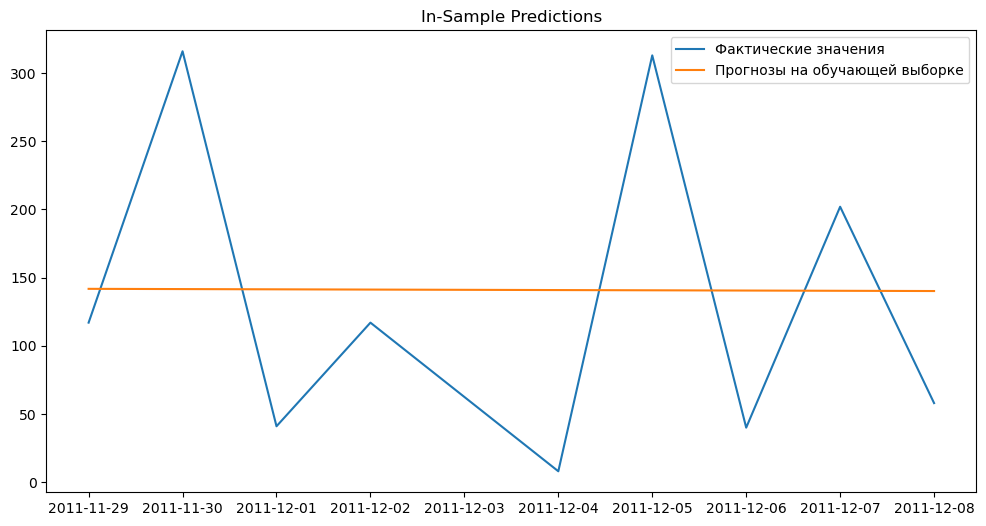

In [190]:
# 5. Визуализация
plt.figure(figsize=(12, 6))
plt.plot(sample_predictions.index, sample_predictions['Quantity'], label='Фактические значения')
plt.plot(sample_predictions.index, sample_predictions['Sample_Pred'], label='Прогнозы на обучающей выборке')
plt.legend()
plt.title('In-Sample Predictions')
plt.show()

## Метрики качества 

In [191]:
# Оценка качества модели
mae_arima = mean_absolute_error(X_test, sample)
rmse_arima = np.sqrt(mean_squared_error(X_test, sample))
r2_arima = r2_score(X_test, sample)
print(f'Mean Absolute Error (MAE): {mae_arima}')
print(f'Root Mean Squared Error (RMSE): {rmse_arima}')
print(f'r2_score (r2_score): {r2_arima}')


Mean Absolute Error (MAE): 95.196
Root Mean Squared Error (RMSE): 107.64543306615475
r2_score (r2_score): -0.014784207252606318


In [192]:
r2_score(X_test, sample)

-0.014784207252606318

**Коэффициент детерминации (R²) — это статистический показатель, который представляет собой долю дисперсии зависимой переменной (целевой переменной), объясняемую независимыми переменными (предикторами) в модели регрессии. Он показывает, насколько хорошо модель соответствует данным.**

MAPE = (1/n) * Σ |(yi - ŷi) / yi| * 100

In [193]:
mean_absolute_percentage_error(X_test, sample) * 100

260.74854984913725

**MAPE — это метрика, которая выражает среднюю абсолютную ошибку прогнозов в процентах. Она вычисляется как среднее арифметическое абсолютных процентных разностей между фактическими и прогнозируемыми значениями.**

In [194]:
rmse =  np.sqrt(mean_squared_error(X_test, sample))
print(f'RMSE : {rmse}')

RMSE : 107.64543306615475


**RMSE (среднеквадратическая ошибка) — это метрика, которая измеряет среднюю величину ошибок, совершаемых моделью при прогнозировании. Она вычисляется как квадратный корень из среднего квадрата разностей между фактическими и прогнозируемыми значениями. Чем меньше RMSE, тем лучше модель соответствует данным.**

In [195]:
mean_absolute_error(X_test, sample)

95.196

**MAE (средняя абсолютная ошибка) — это средняя абсолютная разница. Она вычисляется как среднее арифметическое абсолютных разностей между фактическими и прогнозируемыми значениями. В отличие от RMSE, MAE не возводит ошибки в квадрат, поэтому она менее чувствительна к выбросам. Как и в случае с RMSE, чем меньше MAE, тем лучше модель.**


MSLE = 1/n ∑ᵢ₌₁ⁿ ( log(1 + yᵢ) - log(1 + ŷᵢ) )²



In [32]:
mean_squared_log_error(X_test['Quantity'], sample)

1.3514981064296385

**MSLE — это метрика, используемая для оценки моделей регрессии, особенно когда целевая переменная имеет экспоненциальный рост или когда важна относительная разница между фактическими и прогнозируемыми значениями, а не абсолютная.**

### По всем метрикам видно что результат достаточно не точный , что в первую очередь говарит о данных, выбросы(экстремальные значения) которые присутствуют влияют на конечный результат

In [196]:
# 4. Прогнозирование на 10 шагов вперед
n_periods = 20
forecast = model.predict(n_periods=n_periods)

In [197]:
forecast

2011-11-29    141.787620
2011-11-30    141.608509
2011-12-01    141.429623
2011-12-02    141.250964
2011-12-03    141.072530
2011-12-04    140.894322
2011-12-05    140.716339
2011-12-06    140.538581
2011-12-07    140.361047
2011-12-08    140.183738
2011-12-09    140.006652
2011-12-10    139.829790
2011-12-11    139.653152
2011-12-12    139.476737
2011-12-13    139.300544
2011-12-14    139.124575
2011-12-15    138.948827
2011-12-16    138.773302
2011-12-17    138.597998
2011-12-18    138.422916
Freq: D, dtype: float64

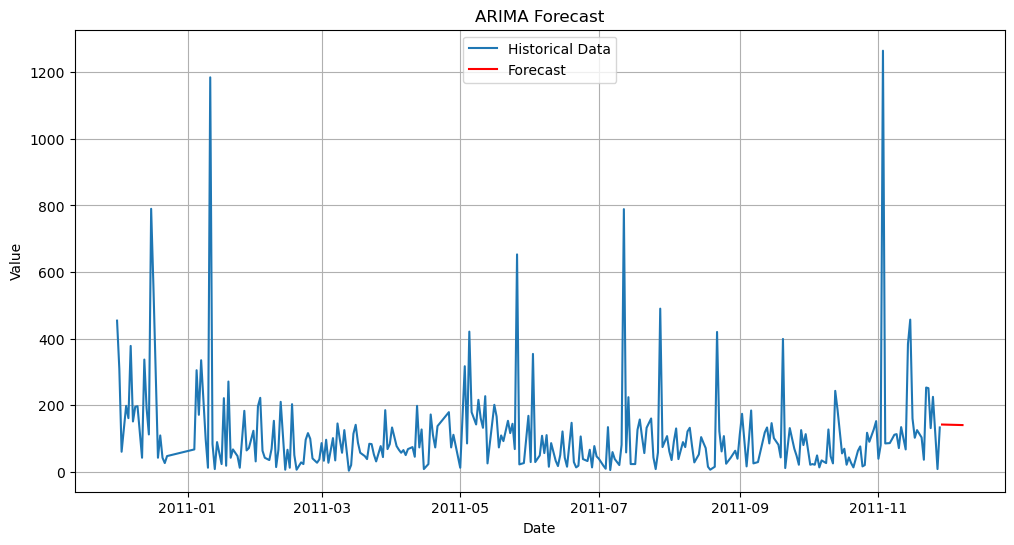

In [198]:
# 7. Визуализация 
plt.figure(figsize=(12, 6))
plt.plot(X_train.index, X_train['Quantity'], label='Historical Data')  # Замените 'YourValueColumn'
plt.plot(sample_predictions.index, sample_predictions['Sample_Pred'], label='Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Forecast')
plt.legend()
plt.grid(True)
plt.show()


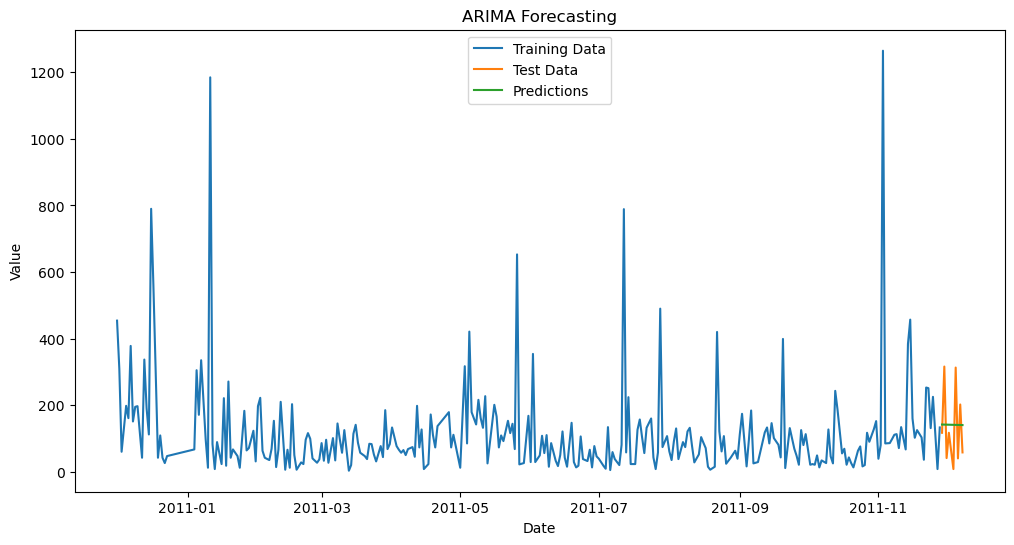

In [199]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(X_train['Quantity'], label='Training Data')
plt.plot(X_test['Quantity'], label='Test Data')
plt.plot(sample_predictions['Sample_Pred'], label='Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Forecasting')
plt.legend()
plt.show;

#### **Можно сделать выводы что для данных в которых есть выбросы модель может не улавливать основные паттерны**

# 4.Prophet

In [200]:
import pandas as pd
from prophet import Prophet
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt


In [202]:
df = pd.read_csv('time_series_data.csv')
# Переименование столбцов для Prophet
df.columns = ['ds', 'y']


In [203]:

# Преобразование столбца ds к datetime
df['ds'] = pd.to_datetime(df['ds'])

In [204]:
# Разделение на обучающую и тестовую выборки 
tscv = TimeSeriesSplit(n_splits=2, test_size=10)

In [205]:
for train_index, test_index in tscv.split(timeseries_one_product):
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    print("Обучающая выборка:")
    print(X_train)
    print("\nТестовая выборка:")
    print(X_test)

Обучающая выборка:
            ds      y
0   2010-12-01  454.0
1   2010-12-02  309.0
2   2010-12-03   60.0
3   2010-12-04  129.0
4   2010-12-05  198.0
..         ...    ...
348 2011-11-14  384.0
349 2011-11-15  457.0
350 2011-11-16  160.0
351 2011-11-17  102.0
352 2011-11-18  125.0

[353 rows x 2 columns]

Тестовая выборка:
            ds      y
353 2011-11-19  114.0
354 2011-11-20  103.0
355 2011-11-21   36.0
356 2011-11-22  253.0
357 2011-11-23  251.0
358 2011-11-24  131.0
359 2011-11-25  225.0
360 2011-11-26  116.5
361 2011-11-27    8.0
362 2011-11-28  133.0
Обучающая выборка:
            ds      y
0   2010-12-01  454.0
1   2010-12-02  309.0
2   2010-12-03   60.0
3   2010-12-04  129.0
4   2010-12-05  198.0
..         ...    ...
358 2011-11-24  131.0
359 2011-11-25  225.0
360 2011-11-26  116.5
361 2011-11-27    8.0
362 2011-11-28  133.0

[363 rows x 2 columns]

Тестовая выборка:
            ds      y
363 2011-11-29  117.0
364 2011-11-30  316.0
365 2011-12-01   41.0
366 2011-12-02  11

У модели Prophet много настраиваемых параметров, например weekly.seasonality — параметр настройки недельной сезонности (т.е. закономерных колебаний в пределах недели). Возможные значения те же, что и у yearly.seasonality.
daily.seasonality — параметр настройки дневной сезонности (т.е. закономерных колебаний в пределах дня). Возможные значения те же, что и у yearly.seasonality.
holidays — таблица, содержащая два обязательных столбца: holiday (текстовая переменная с названиями “праздников” и других важных событий, потенциально влияющих на свойства временного ряда) и ds (даты). Но все они требуют знания предметной области 
changepoint_prior_scale - параметр, задающий чувствительность автоматического механизма обнаружения точек излома в тренде временного ряда y (0.05 по умолчанию). Более высокие значение позволят иметь больше таких точек излома (что одновременно увеличит риск переобучения модели);

In [ ]:
# # Создание  модели Prophet
# model = Prophet(growth='linear',
# changepoint_prior_scale=0.05,
# seasonality_mode='additive',
# daily_seasonality=False,
# weekly_seasonality=False,
# yearly_seasonality=False,
# holidays=None)

In [206]:
# Создание и обучение модели Prophet
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

In [207]:
# Обучаем
model.fit(X_train) 

19:58:33 - cmdstanpy - INFO - Chain [1] start processing
19:58:34 - cmdstanpy - INFO - Chain [1] done processing


In [208]:
# Создание DataFrame для будущего, включая тестовый период
future = model.make_future_dataframe(periods=len(X_test))  #  Прогноз на длину тестовой выборки



In [209]:
forecast = model.predict(future) #  Предсказываем на будущее, включая тестовую выборку

In [210]:

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())


          ds        yhat  yhat_lower  yhat_upper
0 2010-12-01  265.815135  114.249611  415.421085
1 2010-12-02  321.278539  163.606588  469.164324
2 2010-12-03  249.713225   96.662114  402.091781
3 2010-12-04  232.188036   67.818799  379.484154
4 2010-12-05  214.240889   61.240622  374.691240


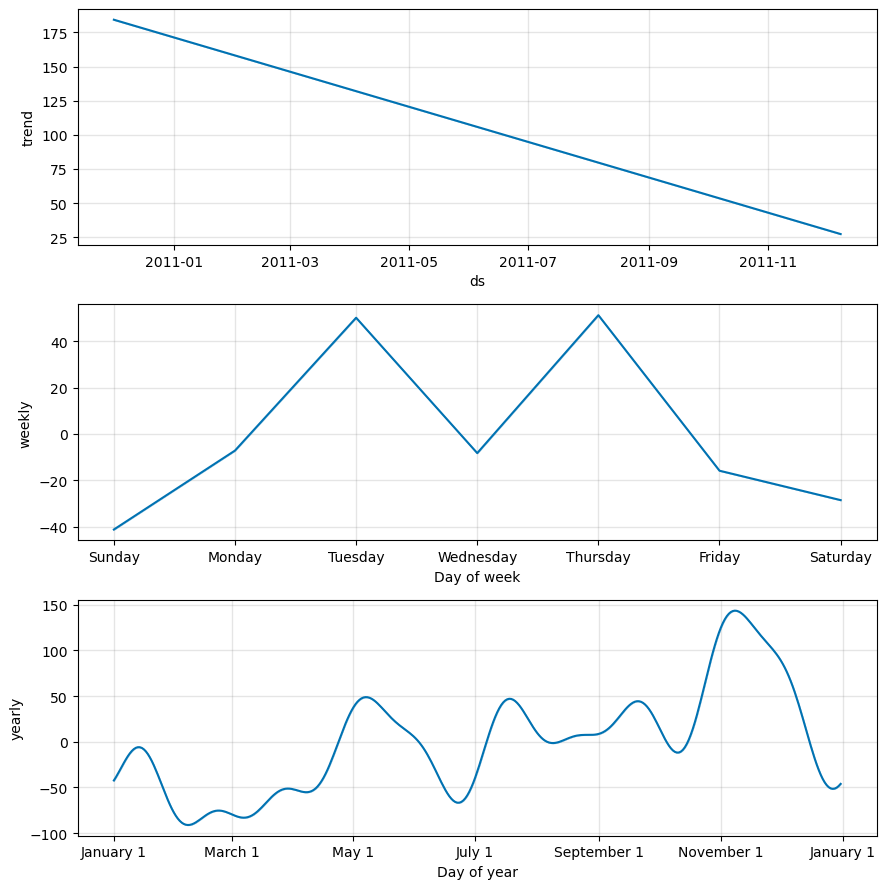

In [211]:
fig2 = model.plot_components(forecast)

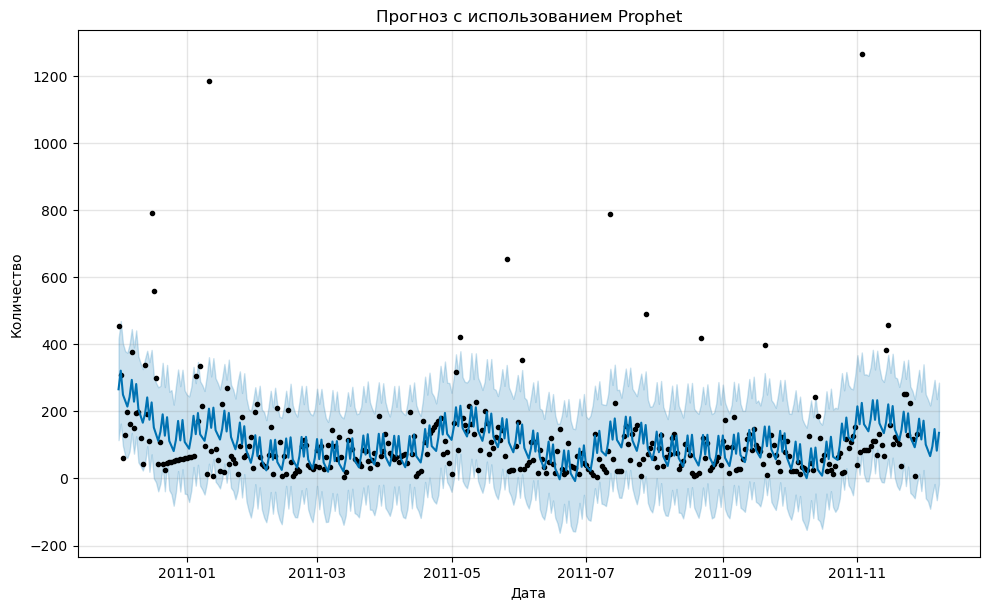

In [212]:
# Визуализация результатов
fig = model.plot(forecast)
plt.title('Прогноз с использованием Prophet')
plt.xlabel('Дата')
plt.ylabel('Количество')
plt.show()

In [213]:
# Получение предсказаний для тестовой выборки
y_pred = forecast['yhat'].values[-len(X_test):]  
y_true = X_test['y'].values


# Метрики качества

In [214]:
# Оценка качества модели
mae_prophet = mean_absolute_error(y_true, y_pred)
rmse_prophet = np.sqrt(mean_squared_error(y_true, y_pred))
r2_prophet = r2_score(y_true,y_pred)

print(f'Mean Absolute Error (MAE): {mae_prophet}')
print(f'Root Mean Squared Error (RMSE): {rmse_prophet}')
print(f'r2_score (r2_score): {r2_prophet}')

Mean Absolute Error (MAE): 100.99404484678311
Root Mean Squared Error (RMSE): 120.01985139003042
r2_score (r2_score): -0.26150405421315637


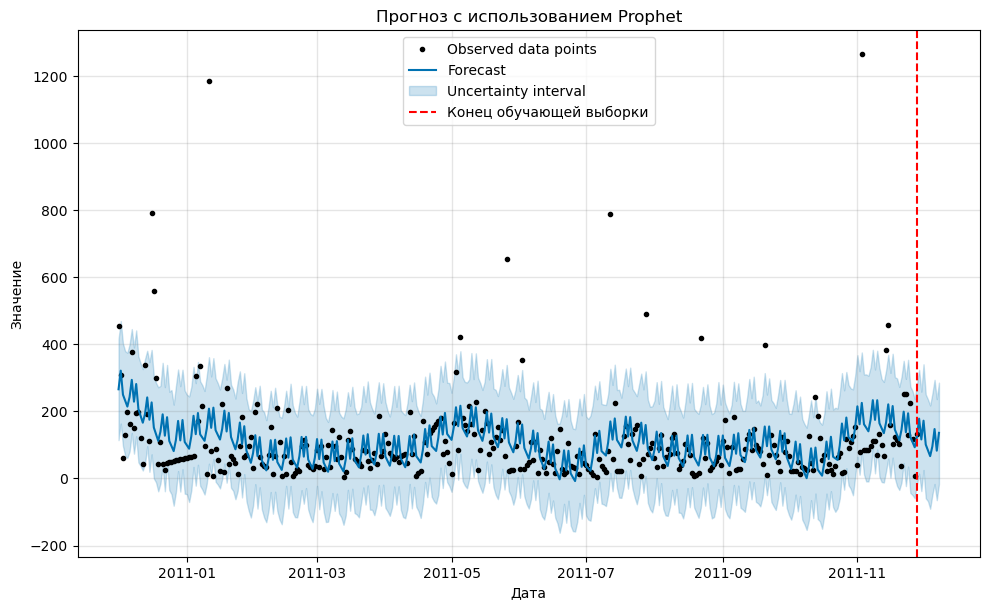

In [215]:
# Визуализация результатов (отдельно обучающая и тестовая выборки)
fig = model.plot(forecast)
plt.title('Прогноз с использованием Prophet')
plt.xlabel('Дата')
plt.ylabel('Значение')

# Добавляем вертикальную линию, разделяющую обучающую и тестовую выборки
plt.axvline(X_train['ds'].iloc[-1], color='red', linestyle='--', label='Конец обучающей выборки')
plt.legend()  # Покажем легенду
plt.show()

In [216]:
# Выявление выбросов на основе IQR
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1

# Определение границ для выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Фильтрация выбросов
outliers = df[(df['y'] < lower_bound) | (df['y'] > upper_bound)]

print("Выбросы:")
print(outliers)


Выбросы:
            ds       y
0   2010-12-01   454.0
1   2010-12-02   309.0
6   2010-12-07   378.0
12  2010-12-13   337.0
15  2010-12-16   790.0
16  2010-12-17   558.0
17  2010-12-18   300.0
35  2011-01-05   305.0
37  2011-01-07   335.0
41  2011-01-11  1185.0
49  2011-01-19   271.0
153 2011-05-03   317.0
155 2011-05-05   421.0
176 2011-05-26   653.0
183 2011-06-02   354.0
223 2011-07-12   789.0
239 2011-07-28   490.0
264 2011-08-22   420.0
293 2011-09-20   399.0
337 2011-11-03  1265.0
348 2011-11-14   384.0
349 2011-11-15   457.0
364 2011-11-30   316.0
369 2011-12-05   313.0


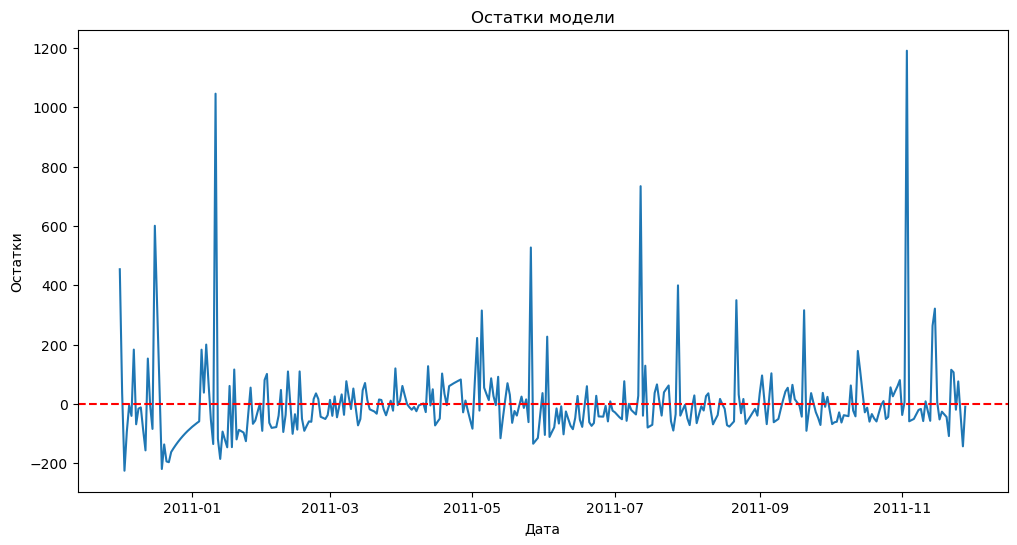

In [217]:


plt.figure(figsize=(12, 6))
plt.plot(X_train['ds'], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Остатки модели')
plt.xlabel('Дата')
plt.ylabel('Остатки')
plt.show()


### **Prophet из коробки показывает результат не лучше чем ARIMA сделать выводы что для данных в которых есть выбросы модель так же может не улавливать основные патерны, но у алгоритма есть гиперпараметры котрые можно добавить для прогнозирования**

# 5.XGboost

In [218]:
data = pd.read_csv('time_series_data.csv',index_col='Date')
data.head()

,Quantity
Date,
2010-12-01,454.0
2010-12-02,309.0
2010-12-03,60.0
2010-12-04,129.0
2010-12-05,198.0


In [219]:
#отсортированы по времени
data.sort_index(inplace=True)

In [220]:
data.index = pd.to_datetime(data.index)

#### XGboost  работает по другим критериям , необходимо создать признаки для прогнозирования,но необходимо проверить качества для тех призаков которые есть создадим только для времени

In [221]:
# Создание признаков на основе дат
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['dayofyear'] = data.index.dayofyear
data['quarter'] = data.index.quarter
data['weekofyear'] = data.index.isocalendar().week.astype(int)

In [222]:
data.head()

,Quantity,month,day,dayofweek,dayofyear,quarter,weekofyear
Date,,,,,,,
2010-12-01,454.0,12,1,2,335,4,48
2010-12-02,309.0,12,2,3,336,4,48
2010-12-03,60.0,12,3,4,337,4,48
2010-12-04,129.0,12,4,5,338,4,48
2010-12-05,198.0,12,5,6,339,4,48


In [223]:
# Разделение данных на признаки (X) и целевую переменную (y)
X = data.drop('Quantity', axis=1)
y = data['Quantity']

In [224]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.025, shuffle=False)

In [ ]:

#  Масштабирование признаков (обязательно для XGBoost)
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Лучшие гиперпараметры

подбор гипермараметров в других файлах

In [225]:
# 2. Определение параметров для RandomizedSearchCV
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Шаг масштабирования
    ('xgb', xgb.XGBRegressor())   # Шаг моделирования
])

params = {
    'objective': ['reg:squarederror'],
    'booster': ['gblinear'],  # Использовать линейную модель
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [100, 200, 300, 400, 500],
    'reg_alpha': [0, 0.1, 0.5, 1],
    'reg_lambda': [0, 0.1, 0.5, 1]
}


# 3. Создание объекта XGBRegressor
xgb_model = xgb.XGBRegressor(random_state=42)

# 4. Настройка RandomizedSearchCV
n_folds = 5 #  Оптимально  использовать StratifiedKFold, но для регрессии это не всегда применимо
random_search = RandomizedSearchCV(xgb_model,
                                   param_distributions=params,
                                   n_iter=100,  # Количество итераций случайного поиска
                                   scoring='neg_mean_squared_error',
                                   cv=n_folds,
                                   verbose=1,                                  
                                   n_jobs=-1)  #  все доступные ядра

# 5. Обучение RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'booster': ['gblinear'],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2,
                                                          0.3],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500],
                                        'objective': ['reg:squarederror'],
                                        'reg_alpha': [0, 0.1, 0.5, 1],
                                        'reg_lambda': [0, 0.1, 0.5, 1]},
                   scoring='neg_mean_squared_error', verbose=1)

In [226]:
# Вывод лучших параметров
print("Лучшие параметры:", random_search.best_params_)

Лучшие параметры: {'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'reg:squarederror', 'n_estimators': 500, 'learning_rate': 0.01, 'booster': 'gblinear'}


In [227]:
#  Получение лучшей модели
best_model = random_search.best_estimator_

In [228]:
y_train

Date
2010-12-01    454.0
2010-12-02    309.0
2010-12-03     60.0
2010-12-04    129.0
2010-12-05    198.0
              ...  
2011-11-24    131.0
2011-11-25    225.0
2011-11-26    116.5
2011-11-27      8.0
2011-11-28    133.0
Name: Quantity, Length: 363, dtype: float64

In [229]:
x_pred = best_model.predict(X_train)

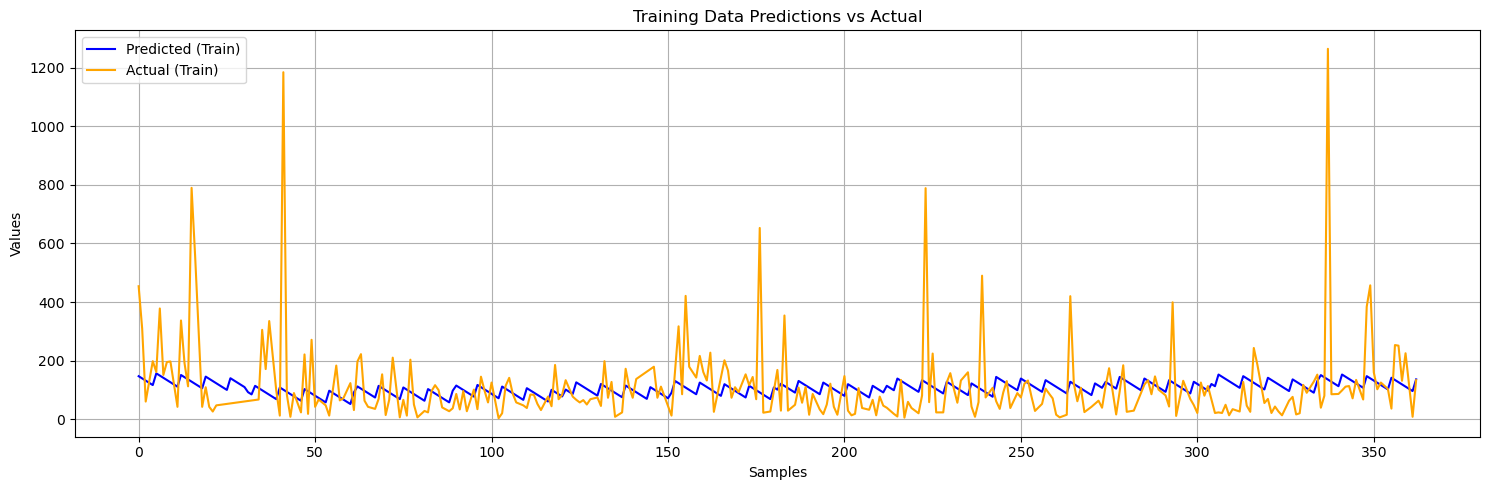

In [232]:
# График для обучающего набора
plt.figure(figsize=(15, 5))
plt.plot(x_pred, label='Predicted (Train)', color='blue')
plt.plot(y_train.values, label='Actual (Train)', color='orange')
plt.title('Training Data Predictions vs Actual')
plt.xlabel('Samples')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [233]:
# Предсказание на тестовой выборке
y_pred = best_model.predict(X_test)


In [234]:
y_pred

array([128.25888, 120.68081, 139.90004, 132.32196, 124.74388, 117.16582,
       157.11324, 149.53516, 141.95708, 134.379  ], dtype=float32)

# Метрики качества

In [240]:
rmse_xgboost = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE на тестовой выборке:", rmse_xgboost)

RMSE на тестовой выборке: 104.79567891793488


In [244]:
mae_xgboost = mean_absolute_error(y_test,y_pred)
print("MAE на тестовой выборке:", mae_xgboost)

MAE на тестовой выборке: 89.40536117553711


In [241]:
mape_xgboost = mean_absolute_percentage_error(y_test, y_pred)*100
print("MAPE на тестовой выборке:", mape_xgboost)

MAPE на тестовой выборке: 227.49651881062317


In [242]:
r2_xgboost=r2_score(y_test, y_pred)
print("R2 на тестовой выборке:", r2_xgboost)

R2 на тестовой выборке: 0.038234415463647475


In [245]:
# 6. Прогнозирование на 10 шагов вперед (от последней даты в *исходных* данных)
last_date = data.index[-1]  # Последняя дата в ИСХОДНЫХ данных
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=10)
X_future = pd.DataFrame(index=future_dates)


In [246]:

# Создаем признаки для будущих дат
X_future['month'] = X_future.index.month
X_future['day'] = X_future.index.day
X_future['dayofweek'] = X_future.index.dayofweek
X_future['dayofyear'] = X_future.index.dayofyear
X_future['quarter'] = X_future.index.quarter
X_future['weekofyear'] = X_future.index.isocalendar().week.astype(int)

In [247]:
# Масштабируем и предсказываем (ИСПОЛЬЗУЕМ Pipeline)
y_future_pred = best_model.predict(X_future) 


In [248]:
# 7. Вывод результатов прогнозирования
print("\nПрогноз на 10 дней вперед (начиная с последней даты в данных):")
print(pd.DataFrame({'Date': future_dates, 'Predicted Quantity': y_future_pred}))


Прогноз на 10 дней вперед (начиная с последней даты в данных):
        Date  Predicted Quantity
0 2011-12-09          126.800926
1 2011-12-10          119.222847
2 2011-12-11          111.644775
3 2011-12-12          151.592194
4 2011-12-13          144.014114
5 2011-12-14          136.436035
6 2011-12-15          128.857971
7 2011-12-16          121.279892
8 2011-12-17          113.701813
9 2011-12-18          106.123734


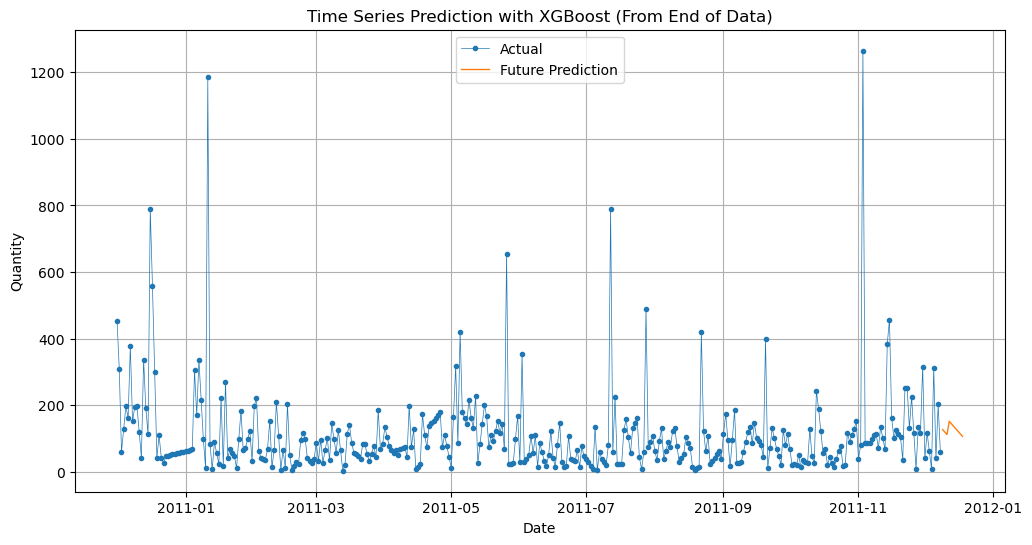

In [249]:
# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Quantity'], label='Actual', marker='.', linestyle='-', linewidth=0.5)  # Plot all actual values
plt.plot(future_dates, y_future_pred, label='Future Prediction', marker='', linestyle='-', linewidth=1)

plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Time Series Prediction with XGBoost (From End of Data)')
plt.legend()
plt.grid(True)
plt.show()

In [250]:
y_pred = np.round((y_pred),2)

In [251]:
# 12. Создание DataFrame для сохранения результатов
results = pd.DataFrame({
    'Actual_Train': y_test,
    'Predicted_Train': y_pred,
})


In [252]:
results

,Actual_Train,Predicted_Train
Date,,
2011-11-29,117.0,128.259995
2011-11-30,316.0,120.680000
2011-12-01,41.0,139.899994
2011-12-02,117.0,132.320007
2011-12-03,62.5,124.739998
2011-12-04,8.0,117.169998
2011-12-05,313.0,157.110001
2011-12-06,40.0,149.539993
2011-12-07,202.0,141.960007


# Построим График 

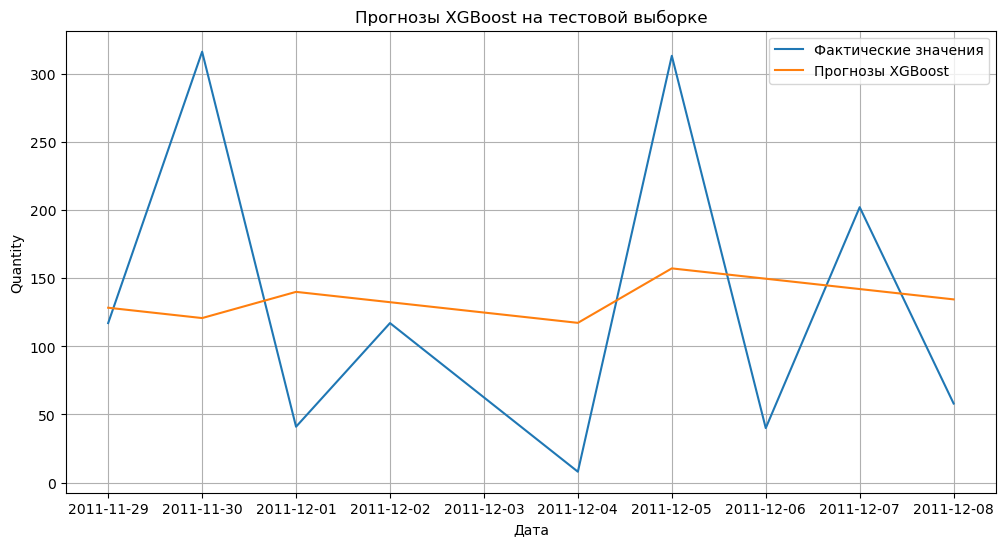

In [253]:
# 8. Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Фактические значения')
plt.plot(y_test.index, y_pred, label='Прогнозы XGBoost')
plt.xlabel('Дата')
plt.ylabel('Quantity')
plt.title('Прогнозы XGBoost на тестовой выборке')
plt.legend()
plt.grid(True)
plt.show()

# Посмотрим на важность признаков 

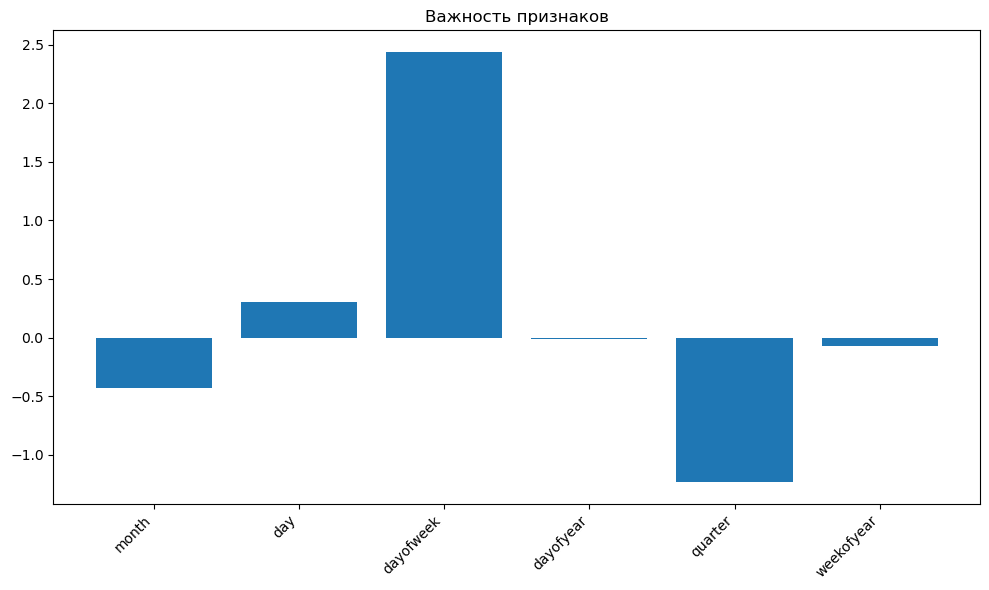

In [257]:
# Важность признаков
importances = best_model.feature_importances_
feature_names = X.columns
plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)
plt.xticks(rotation=45, ha="right")
plt.title('Важность признаков')
plt.tight_layout()
plt.show()

XGB справился не много лучше 

# 6.Сравнить результаты и выбрать наилучший подход для прогнозирования.

In [258]:
calculate_metrics = pd.DataFrame({'Arima':[rmse_arima,r2_arima,mae_arima], 'Prophet' : [rmse_prophet,r2_prophet,mae_prophet],'XGboost' : [rmse_xgboost,r2_xgboost,mae_xgboost]},index=['RMSE', 'R²','MAE'])

In [259]:
calculate_metrics

,Arima,Prophet,XGboost
RMSE,107.645433,120.019851,104.795679
R²,-0.014784,-0.261504,0.038234
MAE,95.196000,100.994045,89.405361


**Подводя итог можно сделать вывод : XGBoost показывает наименьшую ошибку среди трех моделей и положительное значение R², что указывает на лучшую предсказательную способность на данных которые имеют значения, значительно отличающиеся от остальных данных(выбросы).**
 

**Каждый метод имеет свои особенности(настройка гиперпараметров,добавление регрессоров) , учитывая которые можно достичь наиболее точного результата.**

**При прогнозировании товарных запасов важно более детально иследовать значения которые значительно отличаются от остальных исходя из того что они могут являтся частью бизнес процессов и удаление или преобразование их может повлиять на недополучение прибыли по тем дням когда такие события происходят.**